# Statistical Paradoxes in Data Science

Observation bias and sub-group differences can easily produce statistical paradoxes in any data science application.
Here we can see the most common paradoxes encountered in data science with the new language of DAGs.
## Simpson's Paradox

Simpson’s paradox is often presented as a compelling demonstration of why we need statistics education in our schools. It is a reminder of how easy it is to fall into a web of paradoxical conclusions when relying solely on intuition, unaided by rigorous statistical methods. The paradox can demonstrate the limits of statistical methods, and why causal, rather than statistical considerations are necessary to avoid those paradoxical conclusions [Judea Pearl, 2014](https://ftp.cs.ucla.edu/pub/stat_ser/r414.pdf).

Simpson' Paradox occurs when an observed relationship between two variables is reversed when you take into account another variable.

### Example 1: Effective Treatment

Imagine we are trying to work out whether a certain drug is an effective treatment for a disease. To decide whether it is effective, we compare people who took the treatment by examining how many of each recovered from the disease.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import utils as u
from IPython.core.display import HTML

HTML(u.create_table(pd.read_csv("data/Simpson_paradox_binary_example.csv")))

When we just look at the *total* value at the bottom in the table above, we find that of 250 people who took the drug, 110 recovered (44%), whereas out of the 250 people who did not take the drug 177 recovered (71%). From these results it looks like there is a clear advantage to not taking the drug. Unfortunately, this drug was not administered as part of a random controlled trial. This means that the decision of whether or not to take the drug may have been **confounded**.

When we look at different age groups, our conclusion about the drug effectiveness is reversed.

What's worse, is that it is possible that if we take into account another variable the correlation might be reversed again. This is why random controlled trials are so important for separating correlation and causation.

### Example 2: Two Distributions

An effective way to visualize this paradox is considering a continuos distribution example. A simple example would be look at the Covariance between two variables, $x$ and $y$, which is one sign for a collection of subgroups, but a different sign for the whole population.

In [ ]:
def generate_gaussian_simpsons_paradox(n_subgroups=3, n_samples=1000):

    overall_cov = 3*np.array([[1,0.9], [0.9,1]])

    means = np.random.multivariate_normal(mean=[0,0], cov=overall_cov, size=n_subgroups)
    
    weights = np.random.uniform(size=n_subgroups)
    weights /= np.sum(weights)
    covs = [np.random.uniform(0.2,0.8) for _ in range(n_subgroups)]
    covs = [np.array([[1,-c], [-c,1]]) for c in covs]


    samples = []

    for sg, (mean, cov, w) in enumerate(zip(means, covs, weights)):
        n = int(round(n_samples * w))
        sample = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
        sample = pd.DataFrame(sample, columns=["x", "y"])
        sample["z"] = sg
        samples.append(sample)
        
    df = pd.concat(samples)
    
    return df



In [ ]:
np.random.seed(1)

df = generate_gaussian_simpsons_paradox()
print("Total Covariance: {:.3f}".format(df[["x", "y"]].cov().iloc[0,1]))
for z in df.z.unique():
    print("Subgroup {} covariance: {:.3f}".format(z,df[df.z==z][["x", "y"]].cov().iloc[0,1]))

Total Covariance: 2.237
Subgroup 0 covariance: -0.688
Subgroup 1 covariance: -0.252
Subgroup 2 covariance: -0.604


This is clearer if we plot what's going on.

For the overall population, there is a positive correlation between $x$ and $y$:

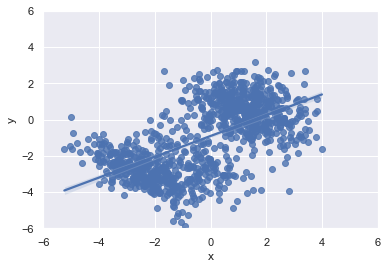

In [ ]:
sns.regplot(data=df, x="x", y="y");
plt.xlim(-6,6);
plt.ylim(-6,6);

However for each subpopulation, the correlation is negative!

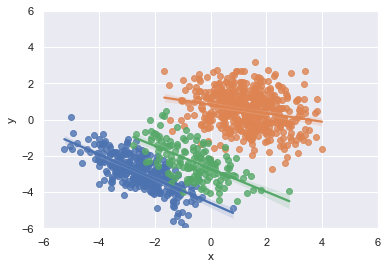

In [ ]:
fig, ax = plt.subplots()

plt.xlim(-6,6);
plt.ylim(-6,6);

for z in df.z.unique():
    sns.regplot(data=df[df.z==z], x="x", y="y", ax=ax)

## Berkson’s Paradox

A first example is the weird **observed negative association** between COVID-19 severity and smoking cigarettes. 
The work of Griffith 2020 recently published on Nature suggests that this can be a case of Collider Bias, also called Berkson’s Paradox

>Griffith, G.J., Morris, T.T., Tudball, M.J. et al. Collider bias undermines our understanding of COVID-19 disease risk and severity. Nat Commun 11, 5749 (2020). https://doi.org/10.1038/s41467-020-19478-2

To understand this paradox, let us consider the following graphical model, where we include a third random variable: "being hospitalized".

<img src="img/ch3/Berkson_paradox_Covid.png" alt="drawing" width="800"/>

This third variable "being hospitalized" is a **collider** of the first two. 
This means that both smoking cigarettes and having severe COVID-19 increase chances of being ill in a hospital. Berkson’s Paradox precisely arises when we condition on a collider, i.e. when we only observe data from hospitalized people rather than considering the whole population.

Let’s consider the following example dataset. In the left figure we have observations from the whole population, while on the right figure we only consider a subset of hospitalized people (i.e. we condition on the collider variable).

<img src="img/ch3/Berkson_paradox_Covid_plot.png" alt="drawing" width="800"/>

In the left figure we can observe the positive correlation between COVID-19 severity and smoking cigarettes that we expected as we know that smoking is a risk factor for respiratory diseases.
However, in the right figure, where we only consider hospital patients, we see the opposite trend! 

To understand this, consider the following points:
- Having high severity of COVID-19 increases chances of being hospitalized. In particular, if severity > 1 hospitalization is required.
- Smoking several cigarettes a day is a major risk factor for a variety of diseases (heart attacks, cancer, diabetes), which increase the chances of being hospitalized for some reason.
- Hence, if a hospital patient has lower COVID-19 severity, they have higher chances of smoking cigarettes! Indeed, they must have some disease different from COVID-19 (e.g. heart attacks, cancer, diabetes) to justify their hospitalization, and this disease may very well be caused by their smoking cigarettes.

## Latent Variables

The presence of a latent variable may also produce an apparently inverted correlation between two variables. While Berkson’s Paradox arises because of the conditioning on a collider variable (which should therefore be avoided), this other kind of paradox can be fixed by conditioning on the latent variable (=fork in a DAG).

Let’s consider, for instance, the relation between number of firefighter deployed to extinguish a fire and the number people that are injured in the fire. 
We would expect that having more firefighters would improve the outcome, yet a positive correlation is observed in aggregated data: the more firefighters are deployed, the higher the number of injured!

To understand this paradox, let us consider the following graphical model. The key is to consider again a third random variable: “fire severity”.

<img src="img/ch3/Fork_paradox_fire.png" alt="drawing" width="800"/>

This third latent variable positively correlates with the other two. Indeed, more severe fires tend to cause more injuries, and at the same time they require more firefighters to be extinguished.

Let’s consider the following example dataset. In the left figure we have aggregated observations from all kinds of fires, while on the right figure we only consider observations corresponding to three fixed degrees of fire severity (i.e. we condition our observations on the latent variable).

<img src="img/ch3/Fork_paradox_fire_plot.png" alt="drawing" width="800"/>

In the right figure, where we condition observations on the degrees of fire severity, we can see the negative correlation we would have expected:

- For a fire of given severity we can indeed observe that the more the firefighters deployed, the fewer the injured people.
- If the we look at fires with higher severity, we observe the same trend even though both number of firefighters deployed and number of injured people are higher.